<a href="https://colab.research.google.com/github/pilatova/prot-viz-data/blob/main/ratios_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

dist = pd.read_csv(
  "https://raw.githubusercontent.com/pilatova/prot-viz-data/main/dist3.tsv",
  sep='\t',           # Tab separator for TSV files
  header=0,           # Use the first row as headers
  index_col=0         # Set the first column as the index
)

goslim = pd.read_csv(
  "https://raw.githubusercontent.com/pilatova/prot-viz-data/main/goslim.tsv",
  sep='\t',           # Tab separator for TSV files
  header=0,           # Use the first row as headers
  index_col=0         # Set the first column as the index
)

goslim_names = pd.read_csv(
  "https://raw.githubusercontent.com/pilatova/prot-viz-data/main/goslim-names.tsv",
  sep='\t',           # Tab separator for TSV files
  header=0,           # Use the first row as headers
  index_col=0         # Set the first column as the index
)

Vypočítame pomery vzdialeností pre všetky rôzne dvojice dvojíc organizmov.

In [2]:
ratios = pd.DataFrame({f'{col1}/{dist.columns[j]}' : dist[col1] / dist[dist.columns[j]]
    for i, col1 in enumerate(dist.columns)
    for j, col2 in enumerate(dist.columns)
    if i != j
})
display(ratios)

,human-baboon/human-cow,human-baboon/human-dog,human-baboon/human-mouse,human-baboon/human-opossum,human-baboon/baboon-cow,human-baboon/baboon-dog,human-baboon/baboon-mouse,human-baboon/baboon-opossum,human-baboon/cow-dog,human-baboon/cow-mouse,...,mouse-opossum/human-opossum,mouse-opossum/baboon-cow,mouse-opossum/baboon-dog,mouse-opossum/baboon-mouse,mouse-opossum/baboon-opossum,mouse-opossum/cow-dog,mouse-opossum/cow-mouse,mouse-opossum/cow-opossum,mouse-opossum/dog-mouse,mouse-opossum/dog-opossum
protein_id,,,,,,,,,,,,,,,,,,,,,
A0A087WTH1,0.187299,0.262769,0.147399,0.084364,0.201586,0.265426,0.125106,0.075318,0.209631,0.133622,...,1.272465,3.040545,4.003456,1.886982,1.136026,3.161894,2.015438,1.124324,2.278692,1.187141
A0A087WZ39,0.274609,0.264516,0.179122,0.110076,0.228486,0.208112,0.169027,0.096283,0.254955,0.218496,...,1.137717,2.361569,2.150982,1.747017,0.995150,2.635146,2.258316,1.268440,2.038516,1.156736
A0A096LP49,0.251271,0.253901,0.234684,0.069499,0.240869,0.250482,0.224003,0.072248,0.291258,0.195504,...,1.068768,3.704134,3.851964,3.444754,1.111046,4.479019,3.006495,1.062269,3.188189,1.086149
A0A0U1RRA0,0.116935,0.153400,0.099922,0.030814,0.103291,0.130726,0.112963,0.031291,0.188882,0.091454,...,1.013060,3.395908,4.297877,3.713877,1.028743,6.209878,3.006726,0.833360,6.153557,0.991757
A0A126GWI2,0.295119,0.350189,0.309850,0.223702,0.299177,0.359948,0.316360,0.229636,0.381919,0.290504,...,0.914933,1.223623,1.472172,1.293899,0.939201,1.562035,1.188150,0.973799,1.366355,1.090290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6Y8,0.207244,0.229855,0.138789,0.100827,0.219079,0.240965,0.140874,0.101283,0.277683,0.146425,...,1.210972,2.631217,2.894072,1.691944,1.216448,3.335072,1.758612,1.277097,1.794281,1.230777
Q9Y6Y9,0.158667,0.229990,0.157452,0.094564,0.166980,0.223387,0.155267,0.101022,0.255247,0.150259,...,1.132337,1.999467,2.674903,1.859207,1.209661,3.056391,1.799237,1.030865,2.041855,1.102700
Q9Y6Z7,0.160652,0.171319,0.090483,0.044962,0.161325,0.170612,0.087667,0.046880,0.209540,0.079208,...,1.111601,3.988483,4.218085,2.167424,1.159034,5.180525,1.958283,1.277534,1.976168,1.260522


In [3]:
def find_extreme_ratio_proteins(species, top_n=300):
  """Funkcia pomocou tabulky ratios najde proteiny, ktore pre dany druh (species)
  maju najvacsi pomer vzdialenosti od ostatnych druhov voci ostatnym parom druhov
  """
  relevant_columns = [name for name in ratios.columns
    if species in name.split('/')[0] and species not in name.split('/')[1]]
  common_extreme_proteins = None
  for col in relevant_columns:
    sorted_ratios = ratios[col].sort_values(ascending=False)
    extreme_ratios = sorted_ratios[:top_n].index
    if common_extreme_proteins is not None:
      common_extreme_proteins = common_extreme_proteins.intersection(set(extreme_ratios))
    else:
      common_extreme_proteins = set(extreme_ratios)
  return common_extreme_proteins

In [4]:
top_n_species_proteins = {}
top_n_species_proteins_counts = {}
for top_n in range(100, 1001, 100):
  top_n_species_proteins[top_n] = {}
  top_n_species_proteins_counts[top_n] = {}
  for species in ('human', 'baboon', 'cow', 'dog', 'mouse', 'opossum'):
    top_n_species_proteins[top_n][species] = find_extreme_ratio_proteins(species, top_n)
    top_n_species_proteins_counts[top_n][species] = len(top_n_species_proteins[top_n][species])


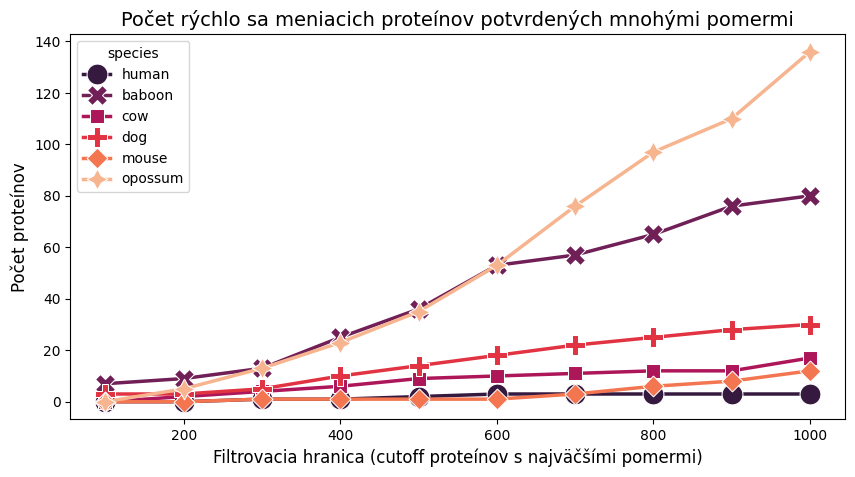

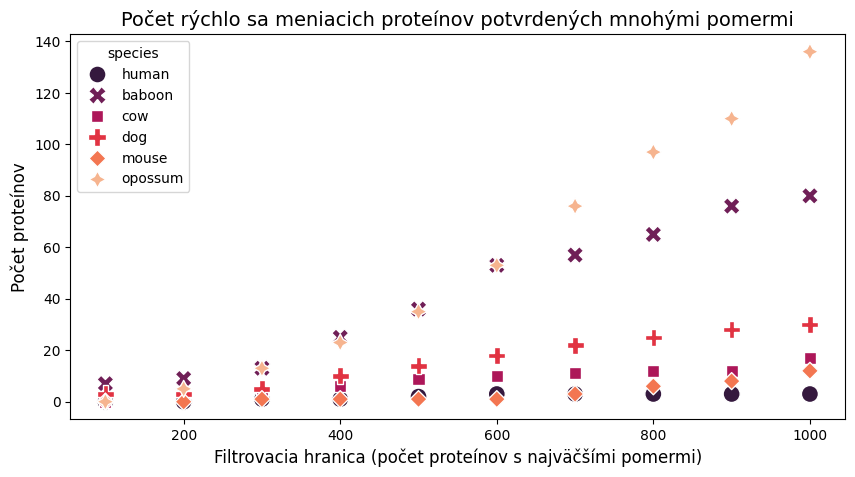

In [5]:
df_counts = pd.DataFrame(top_n_species_proteins_counts)
df_counts_long = df_counts.reset_index().melt(id_vars='index', var_name='top_n',
                                              value_name='count')
df_counts_long.rename(columns={'index': 'species'}, inplace=True)

palette = sns.color_palette("rocket")
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_counts_long, x='top_n', y='count', hue='species',
             style='species', palette=palette, linewidth=2.5,
             markersize=15, markers=True, dashes=False)
plt.title("Počet rýchlo sa meniacich proteínov potvrdených mnohými pomermi", fontsize=14)
plt.xlabel("Filtrovacia hranica (cutoff proteínov s najväčšími pomermi)", fontsize=12)
plt.ylabel("Počet proteínov", fontsize=12)
plt.show()

# alternativny graf
palette = sns.color_palette("rocket")
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_counts_long, x='top_n', y='count', hue='species',
             style='species', palette=palette, s=150)
plt.title("Počet rýchlo sa meniacich proteínov potvrdených mnohými pomermi", fontsize=14)
plt.xlabel("Filtrovacia hranica (počet proteínov s najväčšími pomermi)", fontsize=12)
plt.ylabel("Počet proteínov", fontsize=12)
plt.show()

Z grafu je vidieť, že vačica a pavián majú najväčší počet týchto veľmi rýchlo sa meniacich proteínov, čo možno naznačuje, že sú to druhy, u ktorých životné podmienky podmienili veľa rôznych zmien od čias oddelenia od spoločného predka.

Ďalej sa pozrieme na najčastejšie funkcie ktoré tieto proteíny majú a porovnáme to s najčastejšími funkciami celkovo u všetkých skúmaných proteínov.

In [6]:
def compute_go_frequency_from_proteins(proteins, goslim, goslim_names):
  """Funkcia pomocou údajov z goslim a goslim_names pre dané proteíny (proteins)
  zistí frekvencie funkcií týchto proteínov
  """
  proteins = pd.Series(proteins, name='protein_id')
  proteins_with_go_id = goslim.merge(proteins, on='protein_id', how='inner')
  function_occurrences = proteins_with_go_id.groupby('go_id') \
    .agg(occurrence=('protein_id', 'count')) \
    .sort_values('occurrence', ascending=False)
  function_occurrences['frequency'] = function_occurrences['occurrence'] / len(proteins) * 100
  function_occurrences = function_occurrences.merge(goslim_names, on='go_id', how='inner')
  function_occurrences.rename(columns={'name': 'go_term'}, inplace=True)
  return function_occurrences

Text(0.5, 1.0, 'Distribúcia go term frekvencií u všetkých skúmaných proteínov')

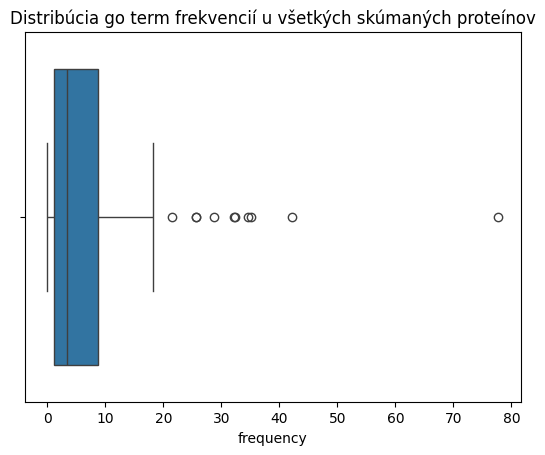

In [7]:
standard_frequency = compute_go_frequency_from_proteins(list(dist.index), goslim, goslim_names)
sns.boxplot(x=standard_frequency['frequency'])
plt.title('Distribúcia go term frekvencií u všetkých skúmaných proteínov')

Vyberieme outliery, čo sú funkcie s frekvenciou $\geq 20\%$.

In [8]:
def compute_frequencies_for_all(selected_n, top_n_species_proteins, goslim, goslim_names):
  species_list = []
  all_frequencies = []
  counts = []
  for species, proteins in top_n_species_proteins[selected_n].items():
    frequencies = compute_go_frequency_from_proteins(list(proteins), goslim, goslim_names)
    counts.append(len(proteins))
    frequencies['species'] = species
    all_frequencies.append(frequencies)
    species_list.append(species)
  return species_list, all_frequencies, counts

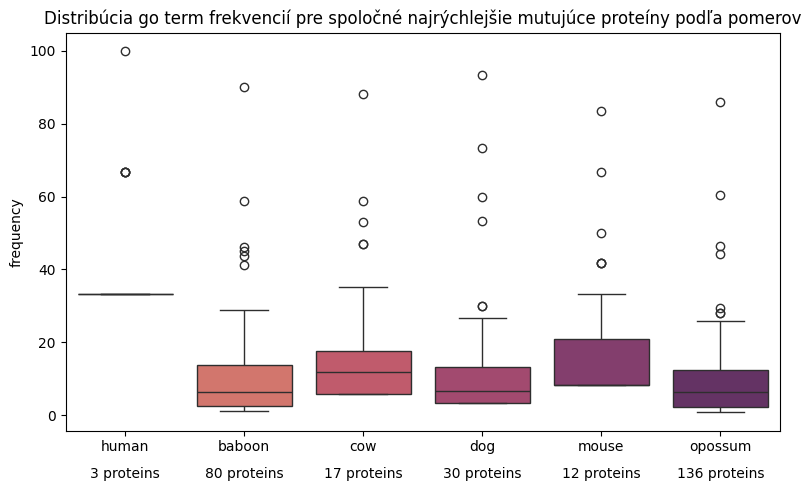

In [9]:
species_list, all_frequencies, counts = compute_frequencies_for_all(1000, top_n_species_proteins, goslim, goslim_names)
frequencies = pd.concat(all_frequencies)
plt.figure(figsize=(8, 5))
ax = sns.boxplot(data=frequencies, x='species', y='frequency', hue='species', palette='flare')

for tick, species in enumerate(ax.get_xticklabels()):
  name = species.get_text()
  n = counts[tick]
  ax.text(tick, ax.get_ylim()[0] - 10, f'{n} proteins',
          ha='center', va='top', fontsize=10, color='black')
plt.title('Distribúcia go term frekvencií pre spoločné najrýchlejšie mutujúce proteíny podľa pomerov')
plt.xlabel('')
plt.tight_layout()

Znova sa zameriame na outliery, čo sú funkcie s frekvenciou približne $\geq 30\%$.

In [10]:
def frequency_barplot(all_frequencies, i, species, ax, min_freq, category='', palette=None):
  most_frequent = all_frequencies[i].query('frequency >= @min_freq')
  # palette = sns.color_palette("flare", as_cmap=True, n_colors=len(most_frequent))
  sns.barplot(most_frequent, y='go_term', x='frequency', legend=False,
              orient='h', hue='go_term', palette=palette, ax=ax)
  if category:
    category = f' pre {category}'
  if species is None:
    ax.set_title('Najčastejšie go termy všetkých skúmaných proteínov v datasete' + category)
  else:
    ax.set_title(f'Najčastejšie go termy rýchlo sa meniacich proteínov u {species}' + category)
  ax.set_xlabel('frequency (%)')
  ax.set_ylabel('')
  ax.tick_params(labelbottom=True)


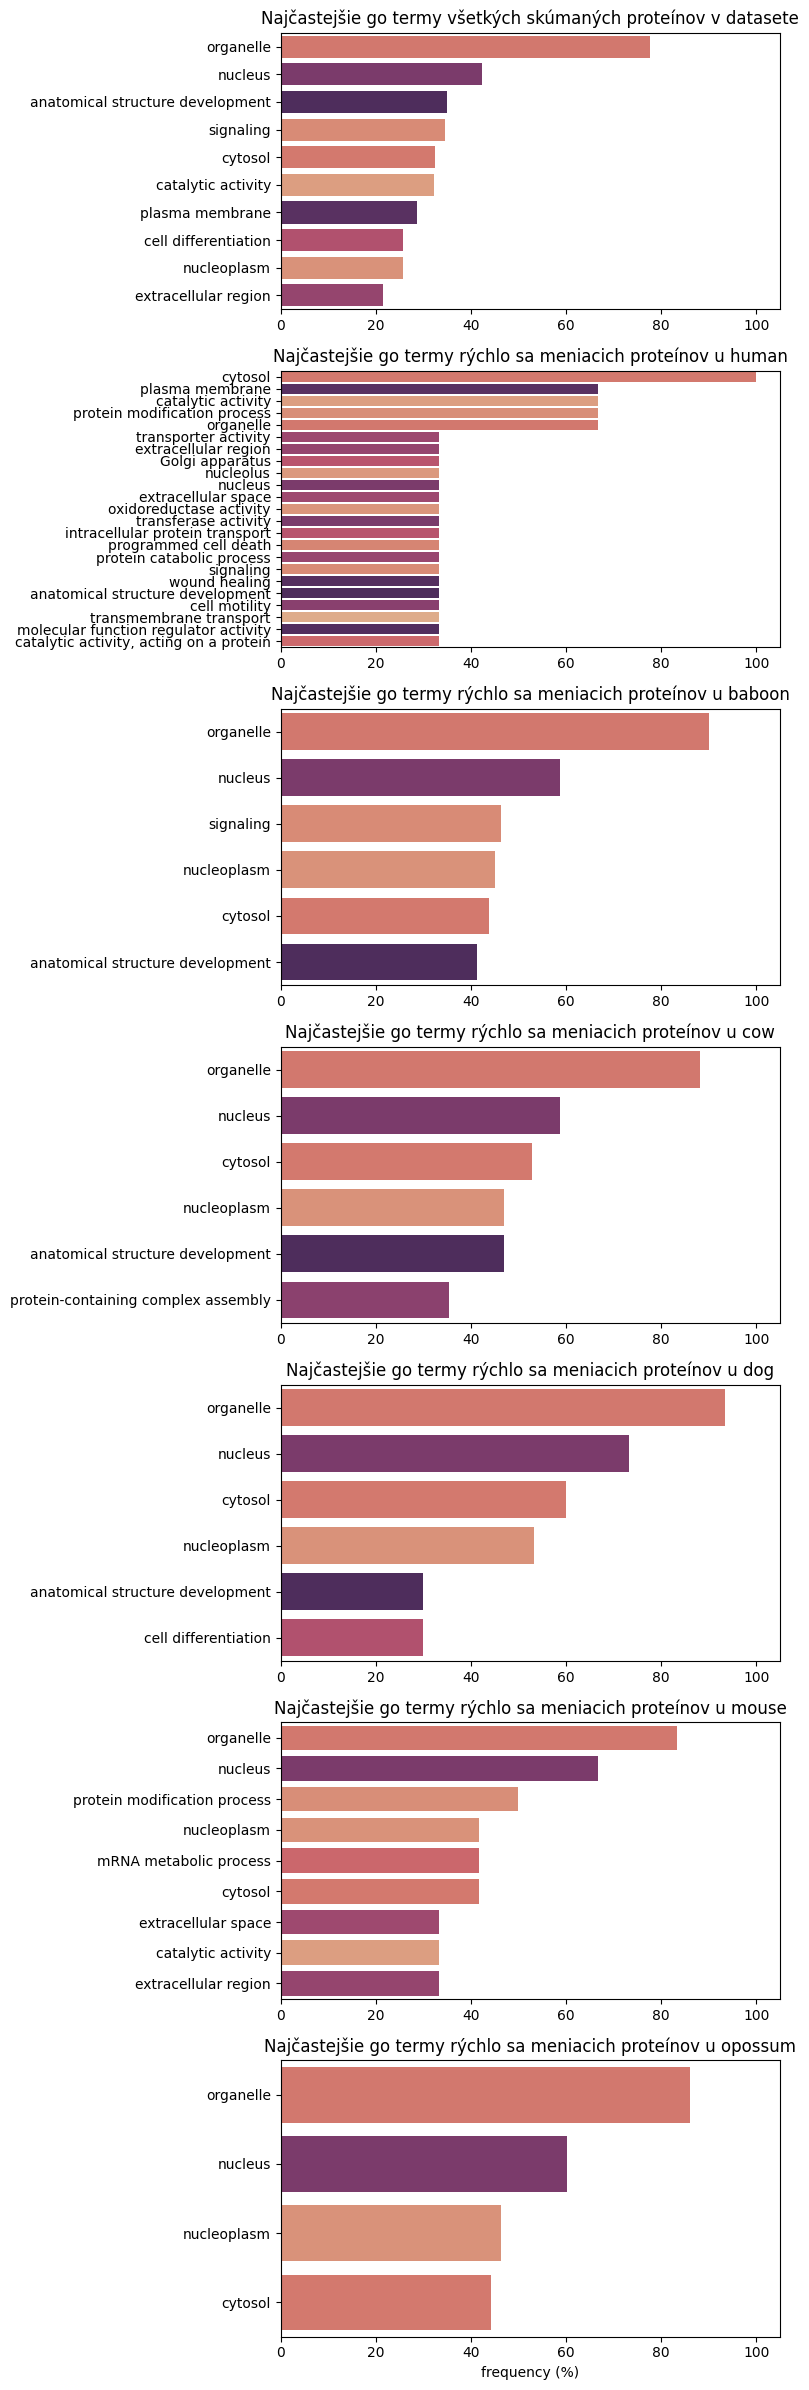

In [11]:
fig, axes = plt.subplots(len(species_list) + 1, 1, figsize=(8, 4 * len(species_list)),
                         sharex=True)


all_functions = set(standard_frequency['go_term'])
for df in all_frequencies:
    all_functions.update(df['go_term'].unique())
function_palette = sns.color_palette("flare", n_colors=len(all_functions))
color_dict = {func: color for func, color in zip(list(all_functions), function_palette)}

frequency_barplot([standard_frequency], 0, None, axes[0], 20, '', color_dict)

for i, (species, ax) in enumerate(zip(species_list, axes[1:])):
  frequency_barplot(all_frequencies, i, species, ax, 30, '', color_dict)

plt.tight_layout()
plt.show()

Okrem človeka, ktorý mal medzi najrýchlejšie sa meniacimi proteínmi iba 3 proteíny sú grafy pre všetky ostatné druhy veľmi podobné grafu pre frekvencie funkcií všetkých skúmaných proteínov v datasete.
Niektoré zmeny sú:

- Funkcie organelle, nucleus majú vyššie frekvencie u rýchlo sa meniacich proteínov

- Pavián má omnoho väčšiu frekvenciu signalling (34 vs 46), cytosol (32 vs 43), nucleoplasm (26 vs 45), chýba mu catalytic activity

- Krava má omnoho väčšiu frekvenciu anatomical structure development (35 vs 47), cytosol (32 vs 53), nucleoplasm (26 vs 47), chýba tam signalling, catalytic activity

- Krava má navyše 35% frekvenciu protein-containing complex assembly

- Pes má omnoho väčšiu frekvenciu cytosol (32 vs 60), nucleoplasm (26 vs 53), chýba tam signalling, catalytic activity

- Myš má omnoho väčšiu frekvenciu nucleoplasm (26 vs 42), chýba tam anatomical structure development, signalling

- Myš má navyše 50% protein modification process, 42%	mRNA metabolic process, 33%	extracellular space

- Vačica má omnoho väčšiu frekvenciu cytosol (32 vs 44), nucleoplasm (26 vs 46), chýba tam anatomical structure development, signalling, catalytic activity


In [12]:
my_query = standard_frequency.query('frequency >= 20')
display(my_query)
function_filter = my_query.index
for x in all_frequencies:
  my_query = x.query('frequency >= 20')
  #valid_filter = [filt for filt in function_filter if filt in my_query.index]
  display(my_query)

,occurrence,frequency,go_term
go_id,,,
GO:0043226,10125,77.764977,organelle
GO:0005634,5500,42.242704,nucleus
GO:0048856,4563,35.046083,anatomical structure development
GO:0023052,4501,34.569892,signaling
GO:0005829,4212,32.350230,cytosol
GO:0003824,4191,32.188940,catalytic activity
GO:0005886,3740,28.725038,plasma membrane
GO:0030154,3346,25.698925,cell differentiation
GO:0005654,3337,25.629800,nucleoplasm


,occurrence,frequency,go_term,species
go_id,,,,
GO:0005829,3,100.000000,cytosol,human
GO:0005886,2,66.666667,plasma membrane,human
GO:0003824,2,66.666667,catalytic activity,human
GO:0036211,2,66.666667,protein modification process,human
GO:0043226,2,66.666667,organelle,human
GO:0005215,1,33.333333,transporter activity,human
GO:0005576,1,33.333333,extracellular region,human
GO:0005794,1,33.333333,Golgi apparatus,human
GO:0005730,1,33.333333,nucleolus,human


,occurrence,frequency,go_term,species
go_id,,,,
GO:0043226,72,90.00,organelle,baboon
GO:0005634,47,58.75,nucleus,baboon
GO:0023052,37,46.25,signaling,baboon
GO:0005654,36,45.00,nucleoplasm,baboon
GO:0005829,35,43.75,cytosol,baboon
GO:0048856,33,41.25,anatomical structure development,baboon
GO:0030154,23,28.75,cell differentiation,baboon
GO:0006351,19,23.75,DNA-templated transcription,baboon
GO:0003824,17,21.25,catalytic activity,baboon


,occurrence,frequency,go_term,species
go_id,,,,
GO:0043226,15,88.235294,organelle,cow
GO:0005634,10,58.823529,nucleus,cow
GO:0005829,9,52.941176,cytosol,cow
GO:0005654,8,47.058824,nucleoplasm,cow
GO:0048856,8,47.058824,anatomical structure development,cow
GO:0065003,6,35.294118,protein-containing complex assembly,cow
GO:0023052,5,29.411765,signaling,cow
GO:0006351,5,29.411765,DNA-templated transcription,cow
GO:0006355,5,29.411765,regulation of DNA-templated transcription,cow


,occurrence,frequency,go_term,species
go_id,,,,
GO:0043226,28,93.333333,organelle,dog
GO:0005634,22,73.333333,nucleus,dog
GO:0005829,18,60.000000,cytosol,dog
GO:0005654,16,53.333333,nucleoplasm,dog
GO:0048856,9,30.000000,anatomical structure development,dog
GO:0030154,9,30.000000,cell differentiation,dog
GO:0006351,8,26.666667,DNA-templated transcription,dog
GO:0006355,8,26.666667,regulation of DNA-templated transcription,dog
GO:0005576,8,26.666667,extracellular region,dog


,occurrence,frequency,go_term,species
go_id,,,,
GO:0043226,10,83.333333,organelle,mouse
GO:0005634,8,66.666667,nucleus,mouse
GO:0036211,6,50.000000,protein modification process,mouse
GO:0005654,5,41.666667,nucleoplasm,mouse
GO:0016071,5,41.666667,mRNA metabolic process,mouse
GO:0005829,5,41.666667,cytosol,mouse
GO:0005615,4,33.333333,extracellular space,mouse
GO:0003824,4,33.333333,catalytic activity,mouse
GO:0005576,4,33.333333,extracellular region,mouse


,occurrence,frequency,go_term,species
go_id,,,,
GO:0043226,117,86.029412,organelle,opossum
GO:0005634,82,60.294118,nucleus,opossum
GO:0005654,63,46.323529,nucleoplasm,opossum
GO:0005829,60,44.117647,cytosol,opossum
GO:0003723,40,29.411765,RNA binding,opossum
GO:0023052,38,27.941176,signaling,opossum
GO:0048856,38,27.941176,anatomical structure development,opossum
GO:0005576,35,25.735294,extracellular region,opossum
GO:0005886,34,25.000000,plasma membrane,opossum


In [13]:
molecular_functions = [
    "virus receptor activity",
    "DNA binding",
    "RNA binding",
    "cytoskeletal motor activity",
    "catalytic activity",
    "GTPase activity",
    "structural molecule activity",
    "transporter activity",
    "cytoskeletal protein binding",
    "lipid binding",
    "cyclase activity",
    "antioxidant activity",
    "oxidoreductase activity",
    "transferase activity",
    "hydrolase activity",
    "lyase activity",
    "isomerase activity",
    "ligase activity",
    "protein tag activity",
    "cargo receptor activity",
    "histone binding",
    "protein folding chaperone",
    "translation regulator activity",
    "receptor ligand activity",
    "molecular transducer activity",
    "molecular adaptor activity",
    "cell adhesion mediator activity",
    "molecular function regulator activity",
    "virus coreceptor activity",
    "catalytic activity, acting on a protein",
    "catalytic activity, acting on DNA",
    "catalytic activity, acting on RNA",
    "molecular carrier activity",
    "transcription regulator activity",
    "general transcription initiation factor activity",
    "molecular sensor activity",
    "molecular sequestering activity",
    "ATP-dependent activity"
]
cellular_components = [
    "nuclear chromosome",
    "extracellular region",
    "extracellular space",
    "nucleus",
    "nuclear envelope",
    "nucleoplasm",
    "chromosome",
    "nucleolus",
    "mitochondrion",
    "lysosome",
    "endosome",
    "vacuole",
    "peroxisome",
    "endoplasmic reticulum",
    "Golgi apparatus",
    "lipid droplet",
    "microtubule organizing center",
    "cytosol",
    "ribosome",
    "cytoskeleton",
    "plasma membrane",
    "cilium",
    "external encapsulating structure",
    "extracellular matrix",
    "cytoplasmic vesicle",
    "organelle"
]
biological_processes = [
    "mitotic cell cycle",
    "cytokinesis",
    "cytoplasmic translation",
    "immune system process",
    "muscle system process",
    "circulatory system process",
    "renal system process",
    "respiratory system process",
    "carbohydrate metabolic process",
    "generation of precursor metabolites and energy",
    "DNA replication",
    "DNA repair",
    "DNA recombination",
    "chromatin organization",
    "DNA-templated transcription",
    "regulation of DNA-templated transcription",
    "tRNA metabolic process",
    "protein folding",
    "protein glycosylation",
    "amino acid metabolic process",
    "modified amino acid metabolic process",
    "lipid metabolic process",
    "vitamin metabolic process",
    "sulfur compound metabolic process",
    "intracellular protein transport",
    "nucleocytoplasmic transport",
    "autophagy",
    "inflammatory response",
    "mitochondrion organization",
    "cytoskeleton organization",
    "microtubule-based movement",
    "peroxisome organization",
    "lysosome organization",
    "chromosome segregation",
    "cell adhesion",
    "establishment or maintenance of cell polarity",
    "programmed cell death",
    "mRNA metabolic process",
    "snRNA metabolic process",
    "vesicle-mediated transport",
    "reproductive process",
    "digestive system process",
    "signaling",
    "cell differentiation",
    "protein catabolic process",
    "extracellular matrix organization",
    "regulatory ncRNA-mediated gene silencing",
    "telomere organization",
    "cell junction organization",
    "protein modification process",
    "wound healing",
    "ribosome biogenesis",
    "cilium organization",
    "anatomical structure development",
    "cell motility",
    "nervous system process",
    "endocrine process",
    "protein maturation",
    "transmembrane transport",
    "nucleobase-containing small molecule metabolic process",
    "membrane organization",
    "protein-containing complex assembly",
    "nitrogen cycle metabolic process",
    "protein localization to plasma membrane",
    "defense response to other organism",
    "detoxification",
    "meiotic nuclear division",
    "mitotic nuclear division",
    "mitochondrial gene expression",
    "carbohydrate derivative metabolic process"
]

categories = {
    'molecular_functions': molecular_functions,
    'cellular_components': cellular_components,
    'biological_processes': biological_processes
}

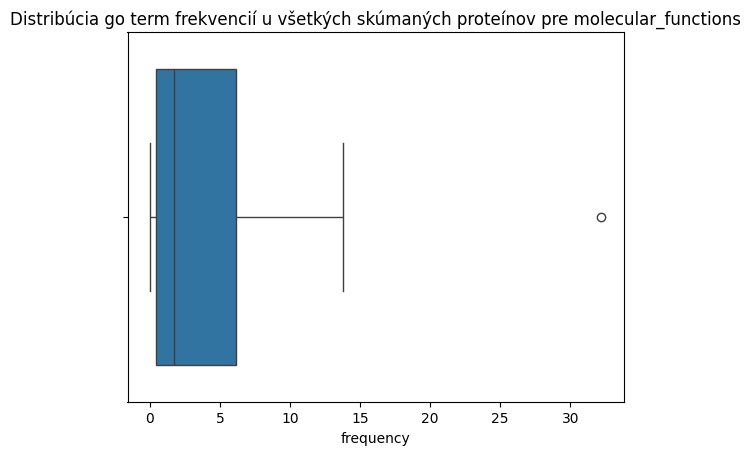

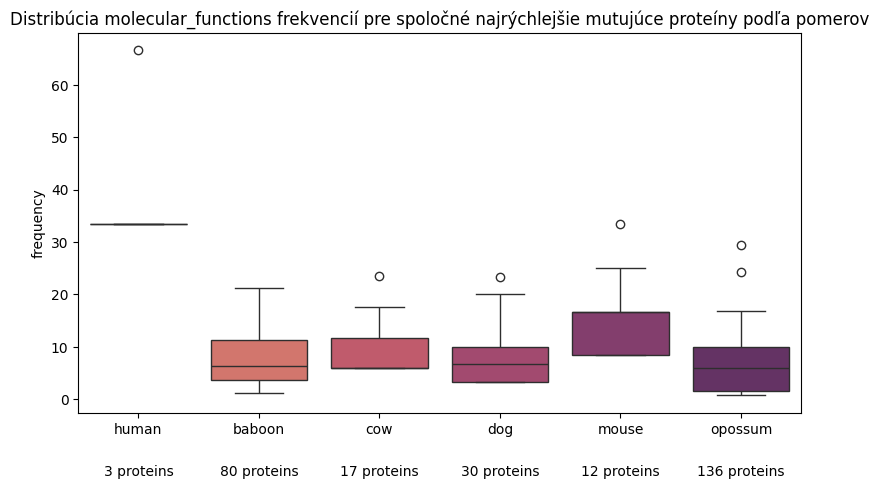

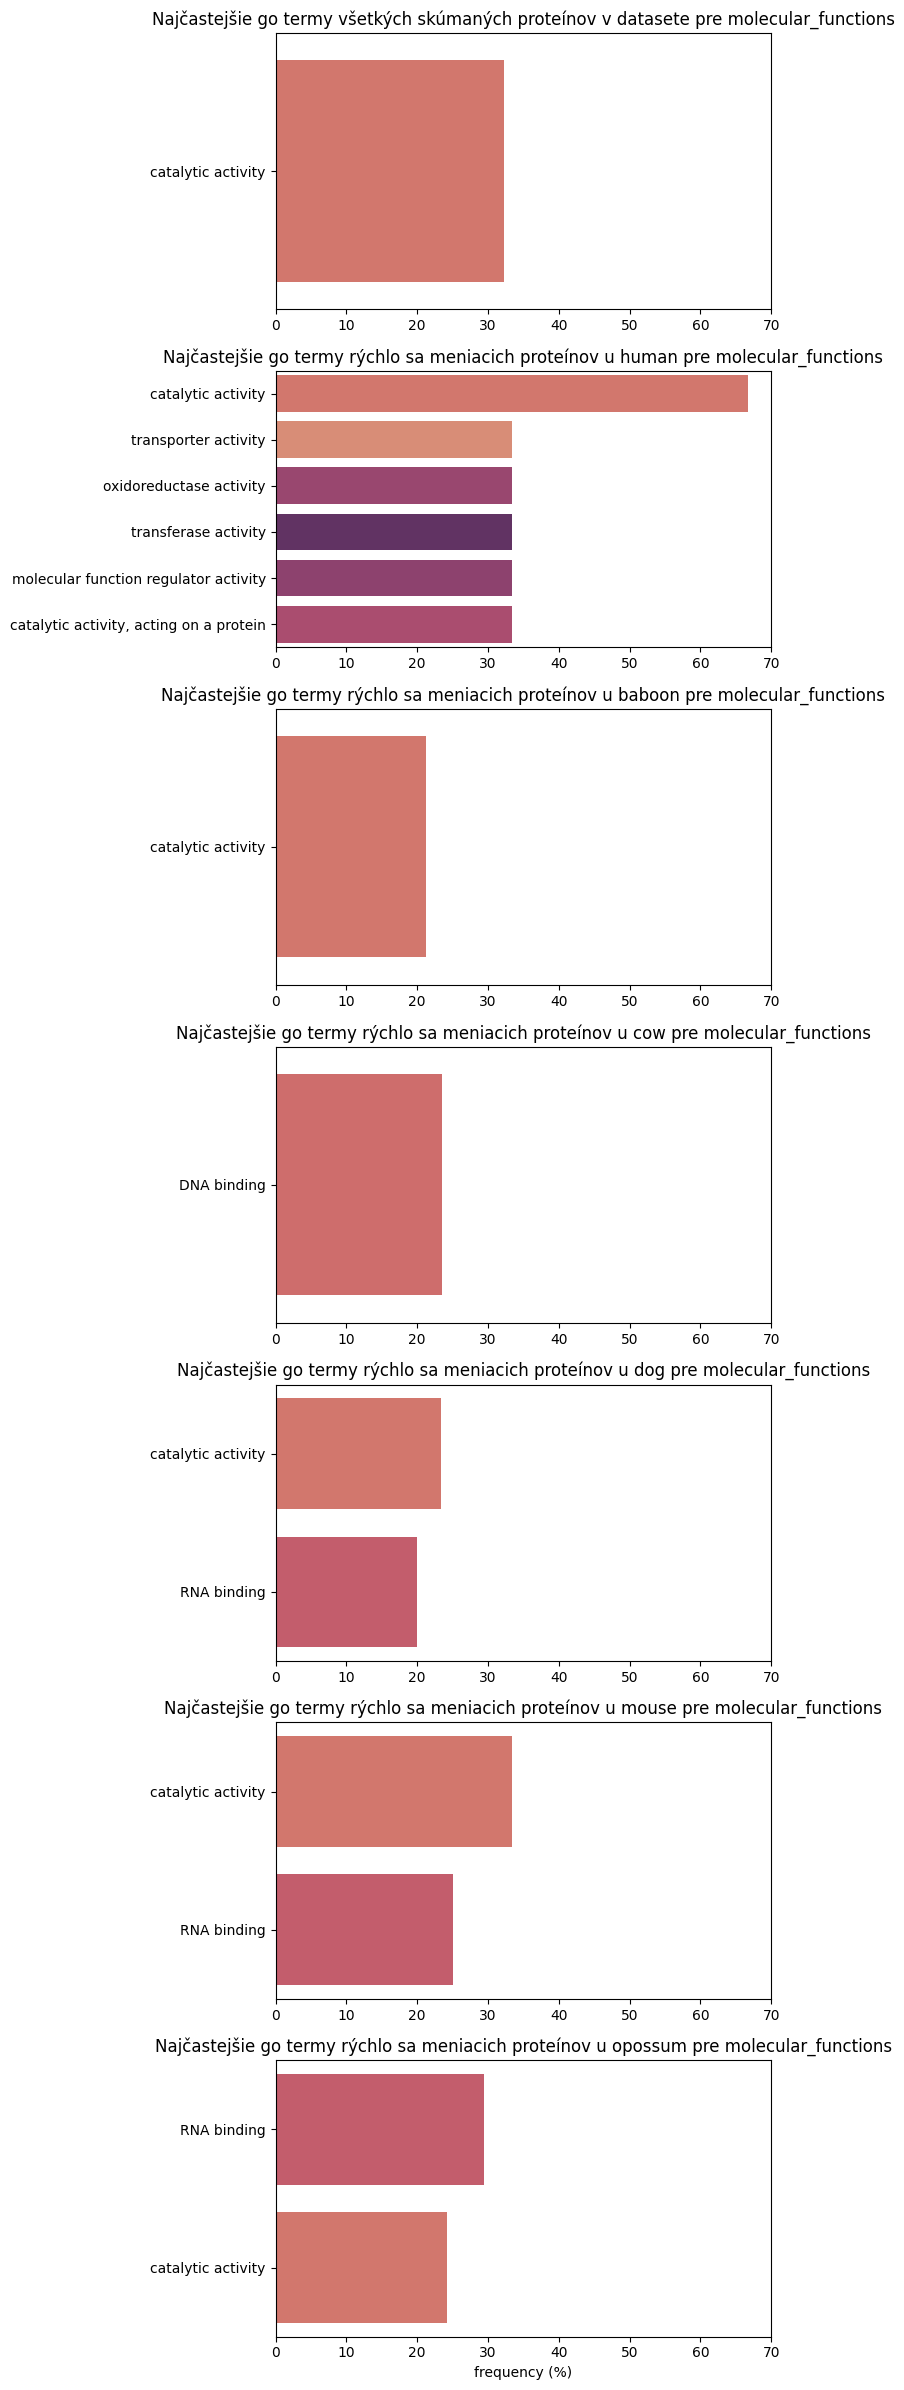

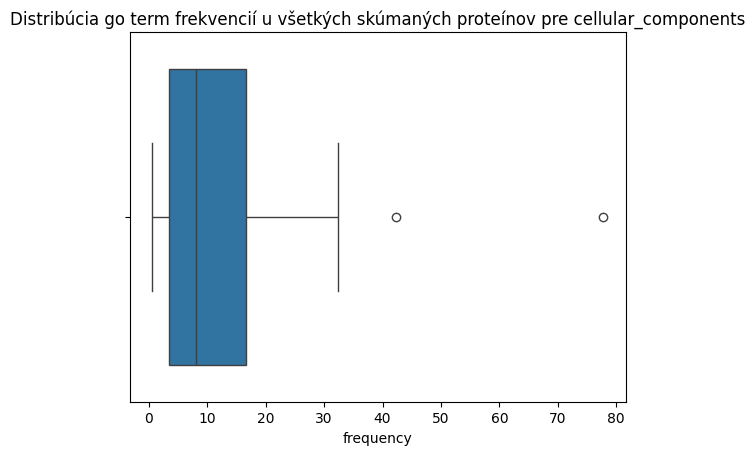

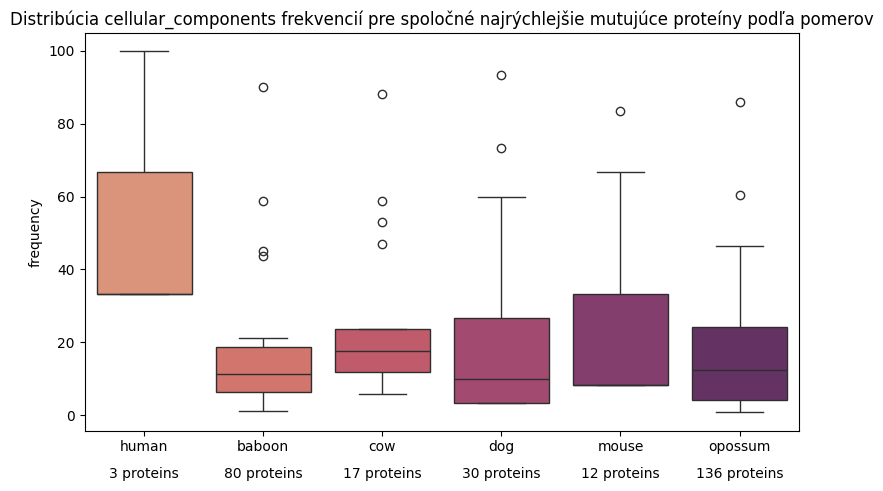

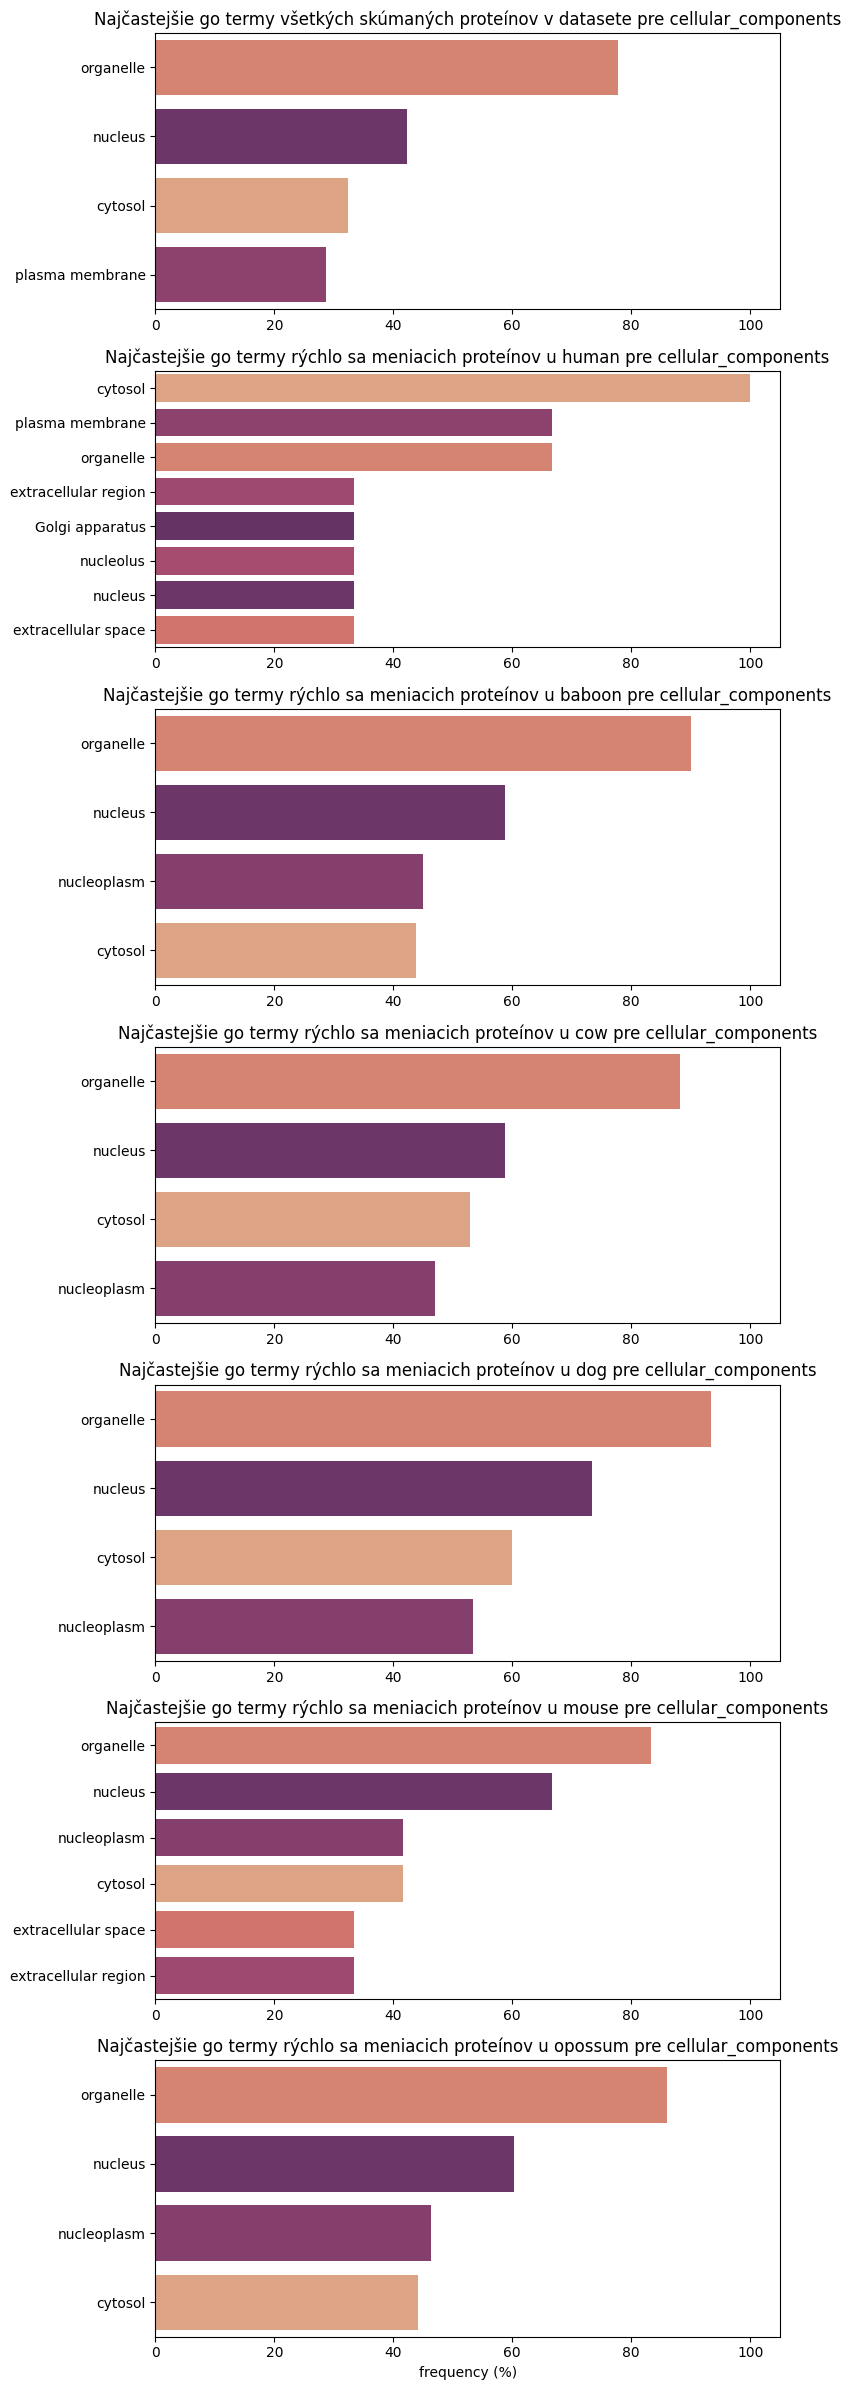

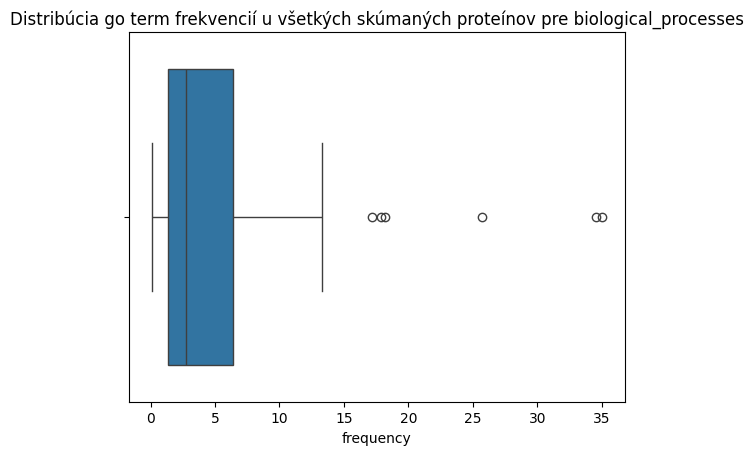

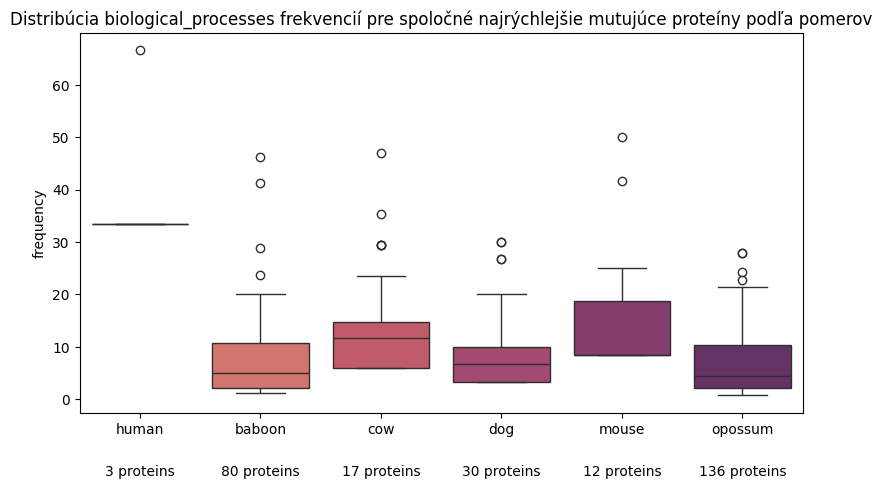

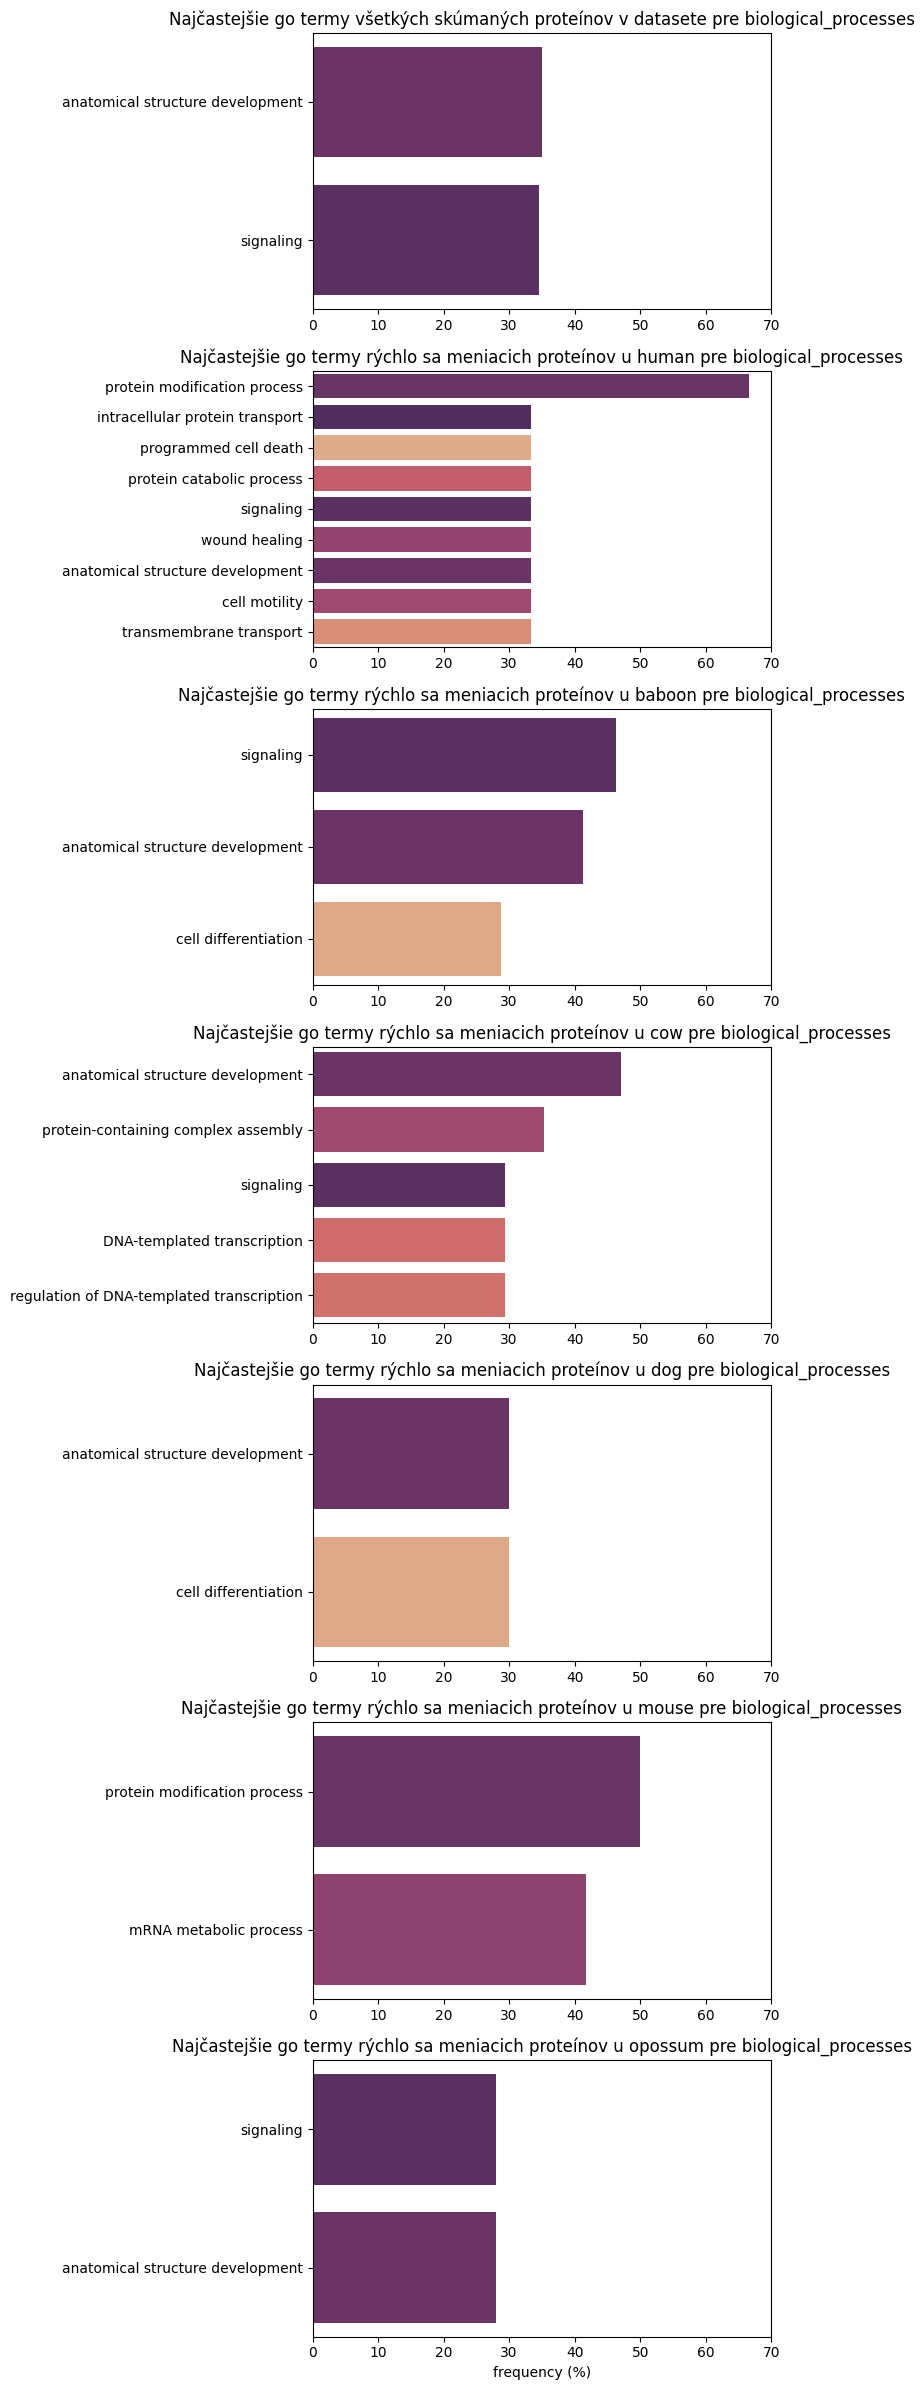

In [14]:
for cat_name, category in categories.items():
  filtered_goslim_names = goslim_names[goslim_names['name'].isin(category)]
  standard_frequency = compute_go_frequency_from_proteins(list(dist.index), goslim, filtered_goslim_names)
  sns.boxplot(x=standard_frequency['frequency'])
  plt.title(f'Distribúcia go term frekvencií u všetkých skúmaných proteínov pre {cat_name}')
  plt.show()

  species_list, all_frequencies, counts = compute_frequencies_for_all(1000,
      top_n_species_proteins, goslim, filtered_goslim_names)

  frequencies = pd.concat(all_frequencies)
  plt.figure(figsize=(8, 5))
  ax = sns.boxplot(data=frequencies, x='species', y='frequency', hue='species', palette='flare')

  for tick, species in enumerate(ax.get_xticklabels()):
    name = species.get_text()
    n = counts[tick]
    ax.text(tick, ax.get_ylim()[0] - 10, f'{n} proteins',
            ha='center', va='top', fontsize=10, color='black')
  plt.title(f'Distribúcia {cat_name} frekvencií pre spoločné najrýchlejšie mutujúce proteíny podľa pomerov')
  plt.xlabel('')
  plt.tight_layout()
  plt.show()

  fig, axes = plt.subplots(len(species_list) + 1, 1, figsize=(8, 4 * len(species_list)),
                          sharex=True)

  all_functions = set(standard_frequency['go_term'])
  for df in all_frequencies:
      all_functions.update(df['go_term'].unique())
  function_palette = sns.color_palette("flare", n_colors=len(all_functions))
  color_dict = {func: color for func, color in zip(list(all_functions), function_palette)}

  if cat_name == 'molecular_functions':
    cutoff = 20
  else:
    cutoff = 27.5

  frequency_barplot([standard_frequency], 0, None, axes[0], cutoff, cat_name, color_dict)

  for i, (species, ax) in enumerate(zip(species_list, axes[1:])):
    frequency_barplot(all_frequencies, i, species, ax, cutoff, cat_name, color_dict)

  plt.tight_layout()
  plt.show()


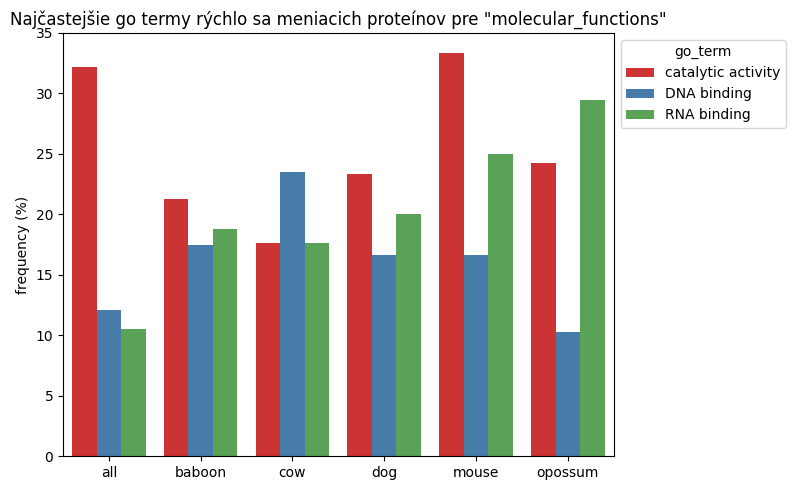

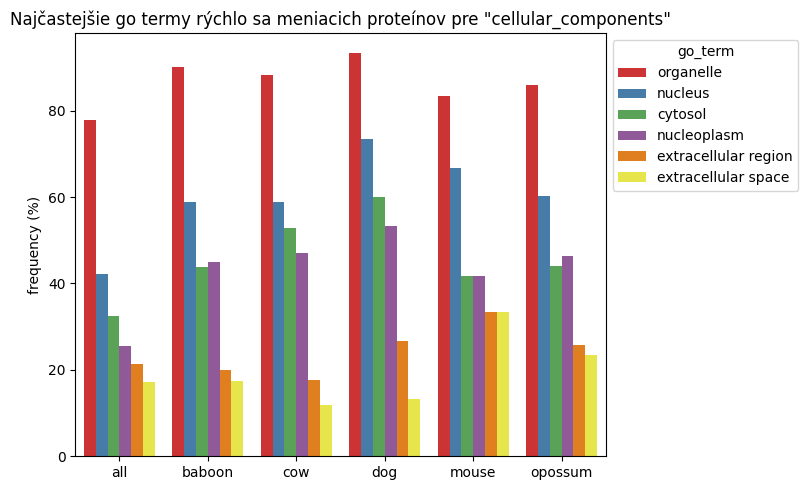

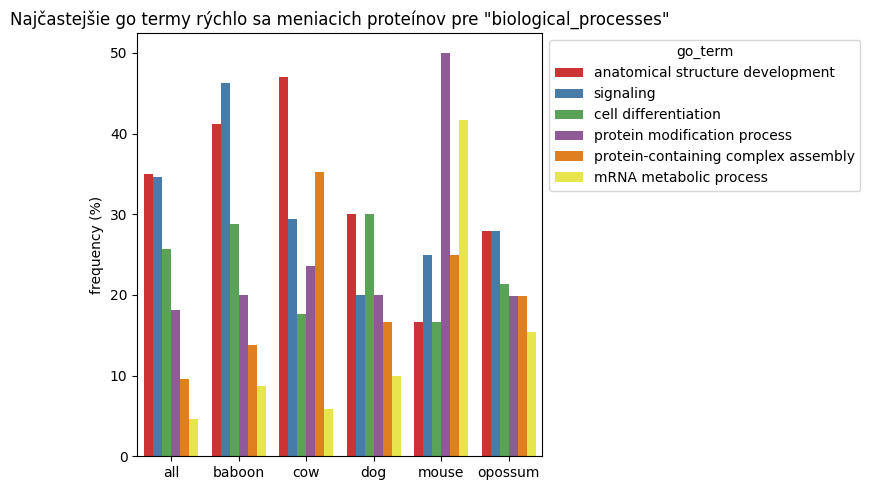

In [15]:
ylims = {'molecular_functions': None,
         'cellular_components': 140,
         'biological_processes': 100}

for cat_name, category in categories.items():
  filtered_goslim_names = goslim_names[goslim_names['name'].isin(category)]
  standard_frequency = compute_go_frequency_from_proteins(list(dist.index), goslim, filtered_goslim_names)

  species_list, all_frequencies, counts = compute_frequencies_for_all(1000,
      top_n_species_proteins, goslim, filtered_goslim_names)
  standard_frequency['species'] = 'all'
  all_frequencies.insert(0, standard_frequency)
  frequencies = pd.concat(all_frequencies).query("species != 'human'")

  if cat_name == 'molecular_functions':
    filtered_frequencies = frequencies.query("frequency >= 20")
  else:
    filtered_frequencies = frequencies.query("frequency >= 30")

  filtered_frequencies = set(filtered_frequencies['go_term'].unique())
  frequencies = frequencies.query('go_term in @filtered_frequencies')

  plt.figure(figsize=(8, 5))

  ax = sns.barplot(frequencies, y='frequency', x='species', hue='go_term', palette='Set1',)

  sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

  # plt.ylim(0, ylims[cat_name])
  plt.title(f'Najčastejšie go termy rýchlo sa meniacich proteínov pre "{cat_name}"')
  plt.ylabel('frequency (%)')
  plt.xlabel('')
  plt.tight_layout()
  plt.show()